In [1]:
import sys
sys.path.append(r'c:\Users\mriffle\IdeaProjects\pygon')

from pygon import PyGON, PyGONTerm

In [2]:
gon = PyGON(ignore_obsolete=False)


Download complete.
Loaded 45667 GO terms from OBO


In [3]:
term_id = 'GO:0000062'

print(gon.get_term(term_id).id)
print(gon.get_term(term_id).name)
print(gon.get_term(term_id).definition)
print(gon.get_term(term_id).parents)


GO:0000062
fatty-acyl-CoA binding
"Binding to a fatty-acyl-CoA, any derivative of coenzyme A in which the sulfhydryl group is in thiolester linkage with a fatty acyl group." [GOC:jl, GOC:krc, ISBN:0198506732]
['GO:1901567', 'GO:0120227']


In [4]:
for aid in gon.get_term_ancestors(term_id):
    print('-------------')
    print(gon.get_term(aid).id)
    print(gon.get_term(aid).name)
    print(gon.get_term(aid).definition)
    print(gon.get_term(aid).parents)
    print('-------------')


-------------
GO:0032555
purine ribonucleotide binding
"Binding to a purine ribonucleotide, any compound consisting of a purine ribonucleoside that is esterified with (ortho)phosphate or an oligophosphate at any hydroxyl group on the ribose moiety." [GOC:mah]
['GO:0032553', 'GO:0017076']
-------------
-------------
GO:0036094
small molecule binding
"Binding to a small molecule, any low molecular weight, monomeric, non-encoded molecule." [GOC:curators, GOC:pde, GOC:pm]
['GO:0005488']
-------------
-------------
GO:0043168
anion binding
"Binding to an anion, a charged atom or group of atoms with a net negative charge." [GOC:jl]
['GO:0043167']
-------------
-------------
GO:0097367
carbohydrate derivative binding
"Binding to a carbohydrate derivative." [GOC:pr]
['GO:0005488']
-------------
-------------
GO:0120227
acyl-CoA binding
"Binding to an acyl-CoA, a thioester that results from the formal condensation of the thiol group of coenzyme A with the carboxy group of any carboxylic acid." 

In [5]:
# pygon_visualization.py
import pygraphviz as pgv
from IPython.display import SVG

def visualize_term_ancestors(gon, go_term_ids, colors=None, extra_info=None):
    ancestors = set()
    for go_term_id in go_term_ids:
        term = gon.get_term(go_term_id)
        if term is None:
            raise ValueError(f"Term ID '{go_term_id}' not found in the ontology.")
        ancestors.update(gon.get_term_ancestors(go_term_id))
        ancestors.add(go_term_id)

    graph = pgv.AGraph(directed=True, rankdir='TB', nodesep=0.5, ranksep=0.8)
    graph.node_attr['shape'] = 'box'
    graph.node_attr['style'] = 'rounded,filled'
    graph.node_attr['fontcolor'] = 'black'
    graph.edge_attr['fontsize'] = '10'
    #graph.edge_attr['label'] = 'is a'
    graph.edge_attr['dir'] = 'forward'
    #graph.edge_attr['dir'] = 'back'

    for ancestor_id in ancestors:
        ancestor_term = gon.get_term(ancestor_id)
        node_attrs = {
            'label': f"{ancestor_id}\n{ancestor_term.name}",
            'fillcolor': colors.get(ancestor_id, 'white') if colors else 'white',
            'color': '#000080'
        }

        if extra_info and ancestor_id in extra_info:
            extra_label = '\n'.join([f"{key}: {value}" for key, value in extra_info[ancestor_id].items()])
            node_attrs['label'] += f"\n{extra_label}"

        graph.add_node(ancestor_id, **node_attrs)

    for ancestor_id in ancestors:
        ancestor_term = gon.get_term(ancestor_id)
        for parent_id in ancestor_term.parents:
            if parent_id in ancestors:
                graph.add_edge(parent_id, ancestor_id)

    svg_data = graph.draw(format='svg', prog='dot')
    return SVG(svg_data)

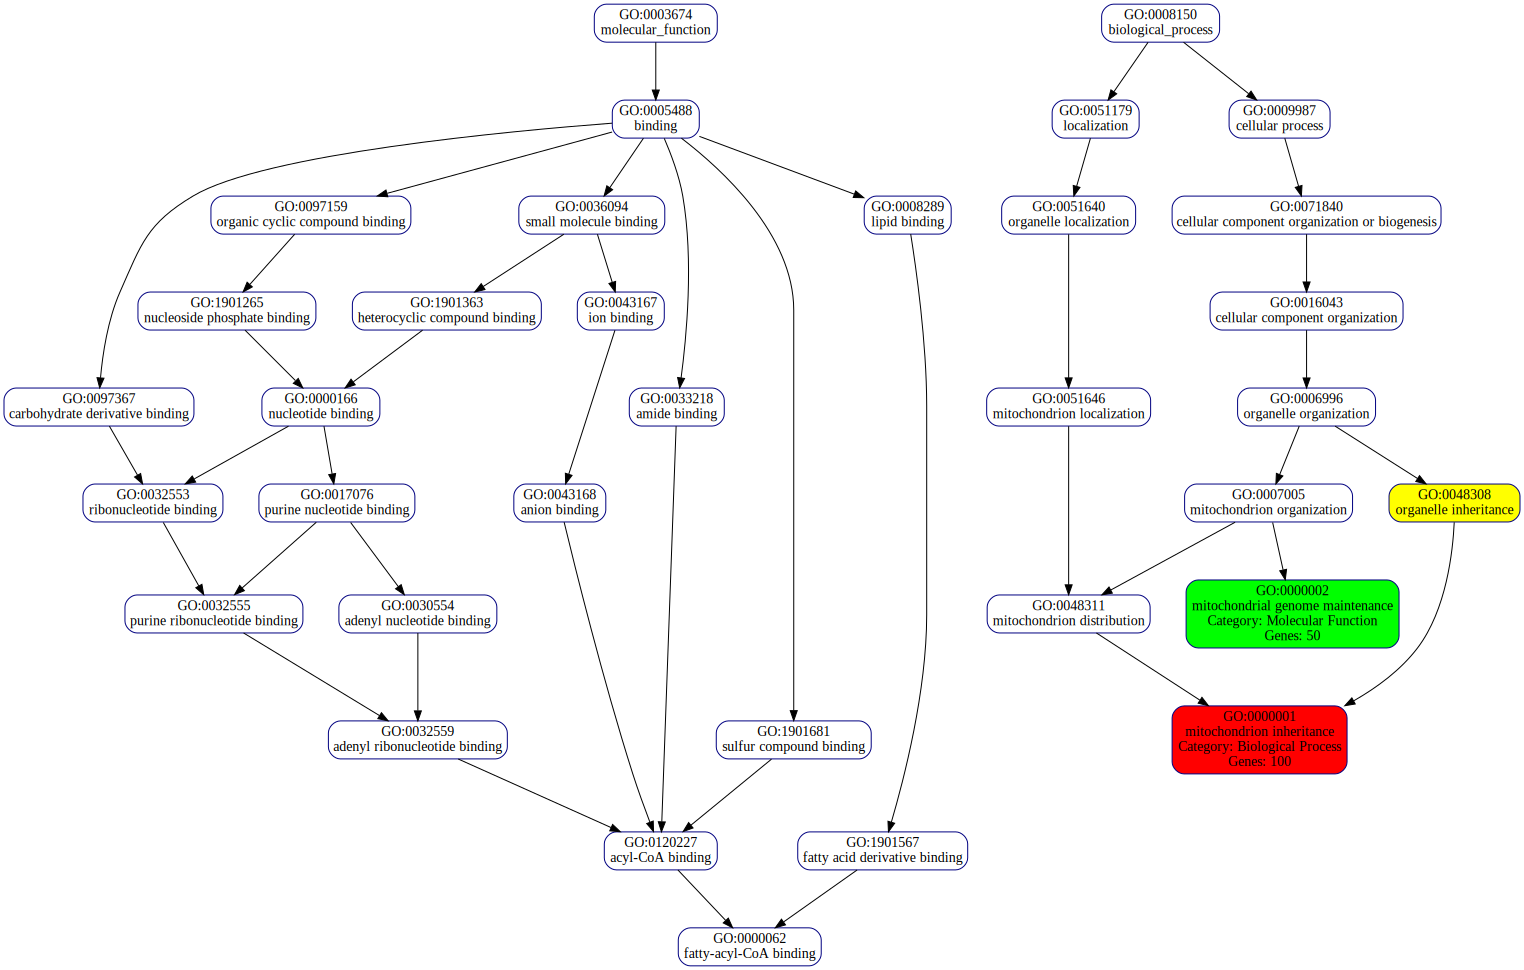

In [6]:
colors = {
    'GO:0000001': '#FF0000',  # Red
    'GO:0000002': '#00FF00',  # Green
    'GO:0048308': '#FFFF00'
}

extra_info = {
    'GO:0000001': {'Category': 'Biological Process', 'Genes': '100'},
    'GO:0000002': {'Category': 'Molecular Function', 'Genes': '50'},
}

go_term_ids = ['GO:0000001', 'GO:0000002','GO:0000062', 'GO:0048308']
visualize_term_ancestors(gon, go_term_ids, colors=colors, extra_info=extra_info)

In [7]:
import requests

# Initialize a cache for GO annotations as an empty dictionary
go_annotations_cache = {}

def extract_uniprot_id(protein):
    """
    Extracts and returns the UniProt ID from a custom ID format.
    
    Parameters:
    protein (str): A protein identifier in the format 'sp|P12345|PROTEIN_NAME' or 'sp|PROTEIN_NAME|'.
    
    Returns:
    str: The UniProt ID part of the protein identifier.
    """
    # Remove the trailing "|" if present
    if protein.endswith("|"):
        protein = protein[:-1]
    
    # Split the string by "|" and return the relevant part
    parts = protein.split("|")
    
    # The UniProt ID or protein name might be in different positions depending on the format
    # Adjust the return statement according to your specific format
    # This example assumes the UniProt ID is always the last part after splitting
    return parts[-1]

def get_go_annotations(uniprot_id):
    """
    Fetches GO IDs for Gene Ontology annotations for a given UniProt ID,
    using a cache to avoid unnecessary web service requests.
    
    Parameters:
    uniprot_id (str): The UniProt ID for which to fetch GO annotations.
    
    Returns:
    set: A set of GO IDs associated with the UniProt ID.
    """
    # Check if the result is already in the cache
    if uniprot_id in go_annotations_cache:
        return go_annotations_cache[uniprot_id]
    
    # Construct the URL
    url = f'https://www.uniprot.org/uniprotkb/{uniprot_id}.json'
    
    # Make the GET request
    response = requests.get(url)
    
    # Initialize an empty set to store GO IDs
    go_ids = set()
    
    if response.status_code == 200:
        data = response.json()
        
        # Look into the 'uniProtKBCrossReferences' section for 'GO' database entries
        for cross_ref in data.get('uniProtKBCrossReferences', []):
            if cross_ref['database'] == 'GO':
                # Extract the GO ID
                go_id = cross_ref['id']
                go_ids.add(go_id)
                
        # Cache the result
        go_annotations_cache[uniprot_id] = go_ids
        return go_ids
    else:
        print(f"Failed to fetch data for UniProt ID {uniprot_id}. Status code: {response.status_code}")
        return set()


In [8]:
custom_id = "sp|P23396|RS3_HUMAN"
uniprot_id = extract_uniprot_id(custom_id)
go_ids = get_go_annotations(uniprot_id)

print(go_ids)

{'GO:0019901', 'GO:0051879', 'GO:0003723', 'GO:1905053', 'GO:0045739', 'GO:0022627', 'GO:0051225', 'GO:0045738', 'GO:0030544', 'GO:0010628', 'GO:0005730', 'GO:0097100', 'GO:0007059', 'GO:0003906', 'GO:0042981', 'GO:0070062', 'GO:0005759', 'GO:0005886', 'GO:2001272', 'GO:0014069', 'GO:0050862', 'GO:0051092', 'GO:0005737', 'GO:0140078', 'GO:1901224', 'GO:0072686', 'GO:0032587', 'GO:0019899', 'GO:0017148', 'GO:0032358', 'GO:0070301', 'GO:0051301', 'GO:0006915', 'GO:0031116', 'GO:0031397', 'GO:0071356', 'GO:0006974', 'GO:0005634', 'GO:2001235', 'GO:0140297', 'GO:0043507', 'GO:0005743', 'GO:0042104', 'GO:0044390', 'GO:0006413', 'GO:0005840', 'GO:0019900', 'GO:0022626', 'GO:0051536', 'GO:0005925', 'GO:0044877', 'GO:0016020', 'GO:0031334', 'GO:0002181', 'GO:0015631', 'GO:0006284', 'GO:0006281', 'GO:0003684', 'GO:0070181', 'GO:0005829', 'GO:0003677', 'GO:0032079', 'GO:1902231', 'GO:0008017', 'GO:0051018', 'GO:0071159', 'GO:0032743', 'GO:1990904', 'GO:0003735', 'GO:0034614', 'GO:0004520', 'GO:0

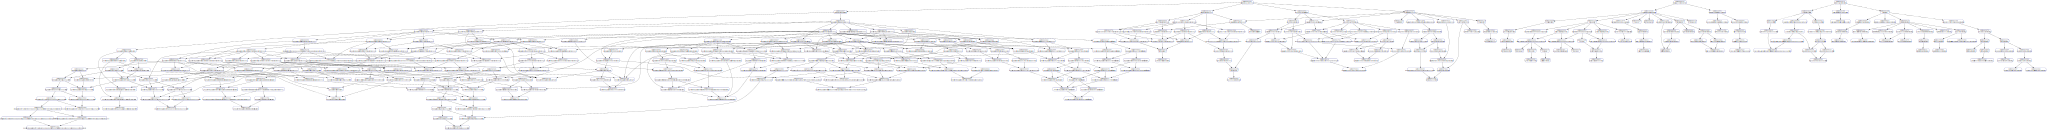

In [9]:
visualize_term_ancestors(gon, go_ids, colors=colors, extra_info=extra_info)

In [10]:
import pandas as pd

# Assuming 'df' is your DataFrame after reading the file
# Replace 'your_file_path.tsv' with the actual path to your tab-delimited file
file_path = 'D:\\Downloads\peptides.txt'
peptides_df = pd.read_csv(file_path, sep='\t')

# Summing the PSM counts across each row, starting from the column after "Protein(s)"
# Adjust the column index of "Protein(s)" as necessary based on your DataFrame
psm_columns = peptides_df.columns[peptides_df.columns.get_loc("Protein(s)") + 1 :]
peptides_df['Total PSMs'] = peptides_df[psm_columns].sum(axis=1)

# Display the first few rows of the DataFrame to verify the new column
print(peptides_df.shape)

(127, 17)


In [11]:
def update_go_term_counts(df, gon):
    go_term_counts = {}

    for index, row in df.iterrows():
        total_psm = row['Total PSMs']  # The total PSM count for the peptide
        # Correctly splitting proteins by ", " (comma and space)
        proteins = row['Protein(s)'].split(', ')

        all_go_terms = set()

        for protein in proteins:
            uniprot_id = extract_uniprot_id(protein.strip())
            go_terms = get_go_annotations(uniprot_id)

            for go_term in go_terms:
                all_go_terms.add(go_term)
                ancestor_terms = gon.get_term_ancestors(go_term)
                all_go_terms.update(ancestor_terms)

        for go_term in all_go_terms:
            go_term_counts[go_term] = go_term_counts.get(go_term, 0) + total_psm

    return go_term_counts

def get_go_proteins(df, gon):
    go_term_proteins = {}  # a dict of go id => set(protein ids)

    for index, row in df.iterrows():
        proteins = row['Protein(s)'].split(', ')
        
        for protein in proteins:
            all_go_terms = set()

            uniprot_id = extract_uniprot_id(protein.strip())
            go_terms = get_go_annotations(uniprot_id)

            for go_term in go_terms:

                if go_term not in go_term_proteins:
                    go_term_proteins[go_term] = set()

                go_term_proteins[go_term].add(protein)

                ancestor_terms = gon.get_term_ancestors(go_term)
                for ancestor_term in ancestor_terms:
                    if ancestor_term not in go_term_proteins:
                        go_term_proteins[ancestor_term] = set()
                    go_term_proteins[ancestor_term].add(protein)

    return go_term_proteins

In [12]:
go_term_counts = update_go_term_counts(peptides_df, gon)
len(go_term_counts)

go_term_proteins = get_go_proteins(peptides_df, gon)
go_term_protein_counts = {key: len(value) for key, value in go_term_proteins.items()}

In [13]:
filtered_go_term_counts = {go_term: psm_count for go_term, psm_count in go_term_counts.items() if psm_count >= 125}
len(filtered_go_term_counts)

99

In [14]:
go_term_extra_data = {go_term: {'PSM count': psm_count} for go_term, psm_count in filtered_go_term_counts.items()}

for go_term, protein_count in go_term_protein_counts.items():
    if go_term in go_term_extra_data:
        go_term_extra_data[go_term]['Protein count'] = protein_count
    else:
        go_term_extra_data[go_term] = {'Protein count': protein_count}

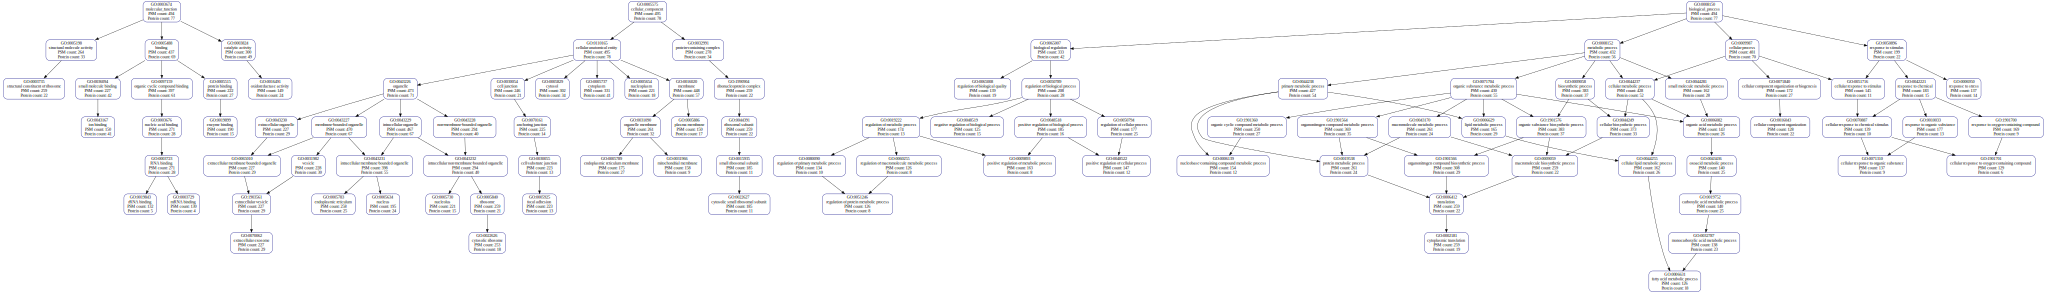

In [15]:
visualize_term_ancestors(gon, filtered_go_term_counts.keys(), extra_info=go_term_extra_data)

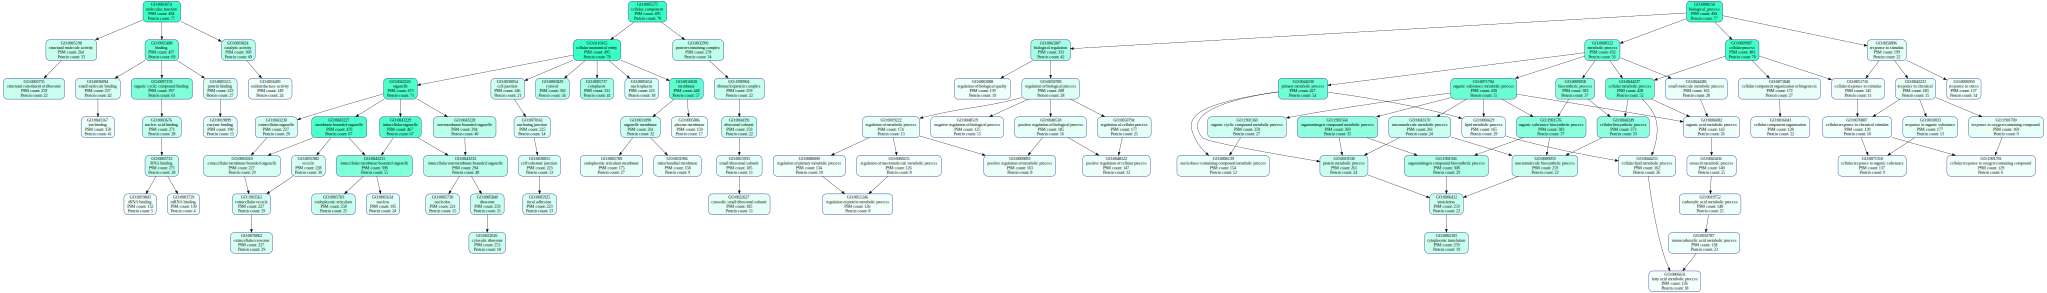

In [16]:
def interpolate_color(min_val, max_val, val, color_start=(255, 255, 255), color_end=(58, 255, 196)):
    val = val * val
    """Interpolate between two colors, returning the color corresponding to val."""
    if max_val - min_val == 0: # Avoid division by zero
        return color_start
    ratio = (val - min_val) / (max_val - min_val)
    r = int(ratio * (color_end[0] - color_start[0]) + color_start[0])
    g = int(ratio * (color_end[1] - color_start[1]) + color_start[1])
    b = int(ratio * (color_end[2] - color_start[2]) + color_start[2])
    return r, g, b

# Assuming go_term_counts is your dictionary
max_psm_count = max(filtered_go_term_counts.values())*max(filtered_go_term_counts.values())

# Creating a color scale dictionary
color_scale_dict = {
    go_term: '#{:02x}{:02x}{:02x}'.format(*interpolate_color(1, max_psm_count, psm_count))
    for go_term, psm_count in filtered_go_term_counts.items()
}

visualize_term_ancestors(gon, filtered_go_term_counts.keys(), colors=color_scale_dict, extra_info=go_term_extra_data)

In [17]:
import numpy as np
from cmap import Colormap
import matplotlib.colors as mcolors

def value_to_hex(value, max_value):

    value = value * value
    max_value = max_value * max_value
    
    # Ensure value is within the allowed range
    value = np.clip(value, 1, max_value)
    
    # Normalize the value to the range [0, 1]
    normalized_value = (value - 1) / (max_value - 1)
    
    # https://cmap-docs.readthedocs.io/en/latest/catalog/
    cmap = Colormap('chrisluts:YGC_3C')
    
    # Use the colormap to get the RGBA color corresponding to the normalized value
    rgba_color = cmap(1-normalized_value)
    #rgba_color = adjust_saturation_and_value(rgba_color)
    
    # Convert the RGBA color to hexadecimal
    hex_color = mcolors.to_hex(rgba_color)
    
    return hex_color

def adjust_saturation_and_value(rgb, saturation_scale=0.7, value_scale=3.5):
    hsv = mcolors.rgb_to_hsv(rgb[:3])
    hsv[1] = max(0, min(1, hsv[1] * saturation_scale))
    hsv[2] = max(0, min(1, hsv[2] * value_scale))
    return mcolors.hsv_to_rgb(hsv)

max_psm_count = max(filtered_go_term_counts.values())

# Creating a color scale dictionary
color_scale_dict = {
    go_term: value_to_hex(psm_count, max_psm_count)
    for go_term, psm_count in filtered_go_term_counts.items()
}


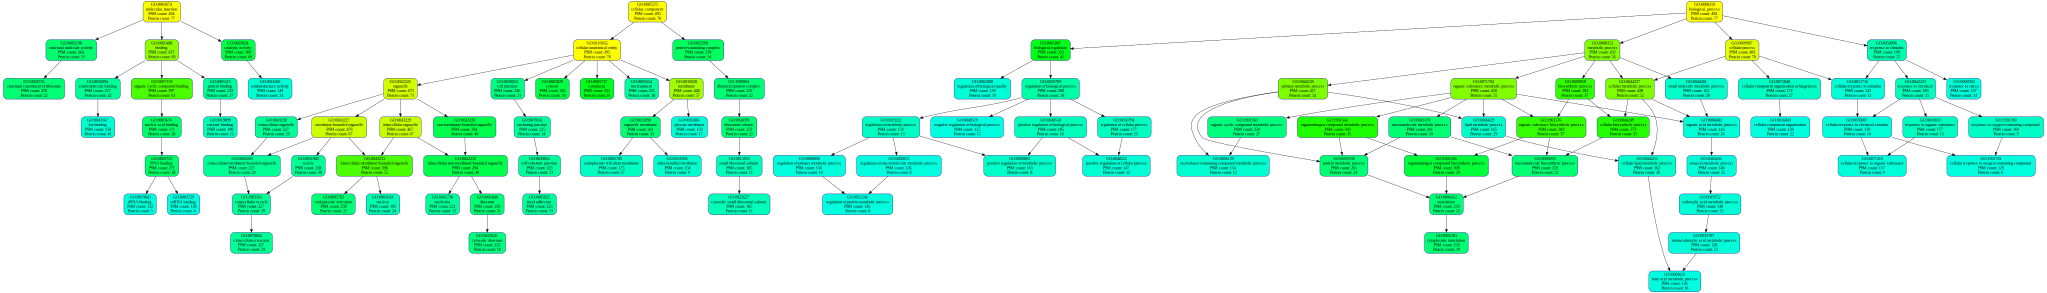

In [18]:
visualize_term_ancestors(gon, filtered_go_term_counts.keys(), colors=color_scale_dict, extra_info=go_term_extra_data)